In [ ]:
!pip install fsspec==2025.3.2 \
nvidia-cublas-cu12==12.4.5.8 \
nvidia-cuda-cupti-cu12==12.4.127 \
nvidia-cuda-nvrtc-cu12==12.4.127 \
nvidia-cuda-runtime-cu12==12.4.127 \
nvidia-cudnn-cu12==9.1.0.70 \
nvidia-cufft-cu12==11.2.1.3 \
nvidia-curand-cu12==10.3.5.147 \
nvidia-cusolver-cu12==11.6.1.9 \
nvidia-cusparse-cu12==12.3.1.170 \
nvidia-nvjitlink-cu12==12.4.127

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



🔧 Training model: cahya/distilbert-base-indonesian


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/230k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/5600 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-2-b502c1b5378c>:146: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

Step,Training Loss


Step,Training Loss
500,0.462500
1000,0.403000


📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.82      0.85       960
    positive       0.76      0.84      0.80       640

    accuracy                           0.83      1600
   macro avg       0.82      0.83      0.82      1600
weighted avg       0.83      0.83      0.83      1600



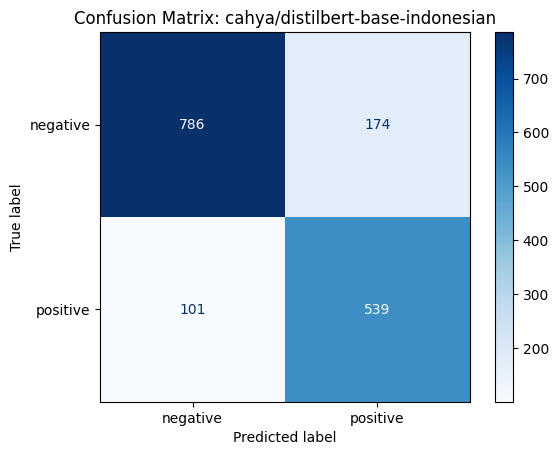

✅ Saved model and tokenizer to saved_models/cahya_distilbert-base-indonesian
✅ Saved metrics to saved_models/cahya_distilbert-base-indonesian/metrics.json


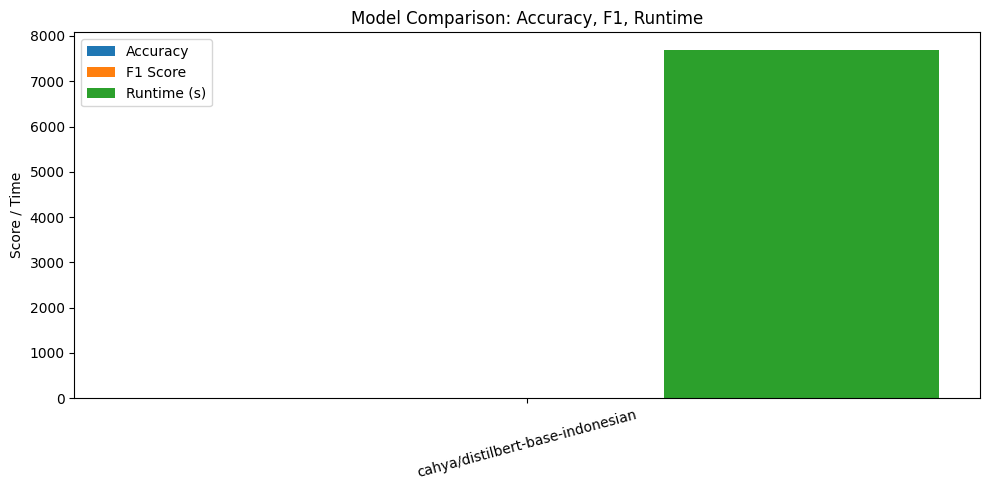

In [ ]:
!pip install -q datasets transformers psutil matplotlib nltk
!pip install --upgrade transformers

import pandas as pd
import numpy as np
import re, time, os, psutil, json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    TrainerCallback
)
from datasets import Dataset
import torch
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("indonesian"))

# Load dataset
df = pd.read_csv("/content/labeled_data (2) (1).csv")
df.columns = df.columns.str.strip()  # Remove any whitespace in column names

# Ensure required columns exist
assert "review" in df.columns, "Missing 'review' column"
assert "sentiment" in df.columns, "Missing 'sentiment' column"

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    return " ".join([word for word in text.split() if word not in stop_words])

# Preprocessing
df["clean_text"] = df["review"].astype(str).apply(preprocess_text)

# Label Encoder
labels = df["sentiment"].astype(str).tolist()
label2id = {label: i for i, label in enumerate(sorted(set(labels)))}
id2label = {i: label for label, i in label2id.items()}
df["label"] = df["sentiment"].map(label2id)

# DATA SPLIT: 70% Train, 20% Test, 10% Validation
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["clean_text"].tolist(),
    df["label"].tolist(),
    test_size=0.3,  # 30% temp for test + validation
    stratify=df["label"],
    random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=2/3,
    stratify=temp_labels,
    random_state=42
)

# Convert to HuggingFace Dataset
def preprocess_data(texts, labels):
    return Dataset.from_dict({"text": texts, "label": labels})

train_dataset = preprocess_data(train_texts, train_labels)
val_dataset = preprocess_data(val_texts, val_labels)
test_dataset = preprocess_data(test_texts, test_labels)

# Disable W&B logging to save memory
os.environ["WANDB_DISABLED"] = "true"
os.makedirs("saved_models", exist_ok=True)  # Create folder to store models

# CUSTOM CALLBACK TO LOG VALIDATION LOSS EVERY 500 STEPS
class LogValidationLossCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if "eval_loss" in logs:
            print(f"Step {state.global_step}: Validation Loss = {logs['eval_loss']}")
            # Store the validation loss in a file
            with open("validation_loss_log.txt", "a") as log_file:
                log_file.write(f"Step {state.global_step}: Validation Loss = {logs['eval_loss']}\n")

# TRAINING FUNCTION
model_metrics = {}

def train_and_evaluate(model_name, label2id, id2label):
    print(f"\n🔧 Training model: {model_name}")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenization
    def tokenize_function(example):
        return tokenizer(example["text"], truncation=True, padding=True)

    encoded_train = train_dataset.map(tokenize_function, batched=True)
    encoded_val = val_dataset.map(tokenize_function, batched=True)
    encoded_test = test_dataset.map(tokenize_function, batched=True)

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )

    # Training configuration
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name.replace('/', '_')}",
        num_train_epochs=2,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        save_strategy="no",
        logging_dir="./logs",
        seed=42,
        report_to="none",
        eval_steps=500,  # Evaluate every 500 steps
        logging_steps=500,  # Log every 500 steps
    )

    # Data collator for dynamic padding
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Initialize Trainer with the custom callback
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=encoded_train,
        eval_dataset=encoded_val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[LogValidationLossCallback]  # Add the custom callback here
    )

    start_time = time.time()
    # Initial memory check before training
    initial_ram_usage = psutil.virtual_memory().used / 1e6
    initial_gpu_mem = torch.cuda.max_memory_allocated() / 1e6 if torch.cuda.is_available() else 0

    trainer.train()

    # Final memory check after training
    end_time = time.time()
    final_ram_usage = psutil.virtual_memory().used / 1e6
    final_gpu_mem = torch.cuda.max_memory_allocated() / 1e6 if torch.cuda.is_available() else 0

    # Evaluation
    preds = trainer.predict(encoded_test)

    # Get prediction labels
    logits = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions
    pred_labels = np.argmax(logits, axis=1)

    acc = accuracy_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels, average="weighted")
    runtime = end_time - start_time

    # Calculate RAM and GPU usage during training
    ram_usage = final_ram_usage - initial_ram_usage
    gpu_mem = final_gpu_mem - initial_gpu_mem

    # Print report
    print("📊 Classification Report:")
    print(classification_report(test_labels, pred_labels, target_names=label2id.keys()))

    # Confusion Matrix
    cm = confusion_matrix(test_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label2id.keys())
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

    # Save metrics
    model_metrics[model_name] = {
        "accuracy": acc,
        "f1_score": f1,
        "runtime_sec": runtime,
        "ram_MB": ram_usage,
        "gpu_MB": gpu_mem
    }

    # Save model and tokenizer
    save_path = f"saved_models/{model_name.replace('/', '_')}"
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"✅ Saved model and tokenizer to {save_path}")

    # --- Save metrics to JSON ---
    metrics_path = os.path.join(save_path, "metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(model_metrics[model_name], f, indent=4)
    print(f"✅ Saved metrics to {metrics_path}")

# List of models to train
model_names_to_train = [
    "cahya/distilbert-base-indonesian",
    #"bert-base-multilingual-cased"
]

# Run one model at a time
for model_name in model_names_to_train:
    train_and_evaluate(model_name, label2id, id2label)

# Extract metrics for plotting
model_names = list(model_metrics.keys())
accuracy = [model_metrics[m]["accuracy"] for m in model_names]
f1_scores = [model_metrics[m]["f1_score"] for m in model_names]
runtime = [model_metrics[m]["runtime_sec"] for m in model_names]

# Bar plot
x = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(10, 5))
plt.bar(x - width, accuracy, width, label="Accuracy")
plt.bar(x, f1_scores, width, label="F1 Score")
plt.bar(x + width, runtime, width, label="Runtime (s)")
plt.xticks(x, model_names, rotation=15)
plt.ylabel("Score / Time")
plt.title("Model Comparison: Accuracy, F1, Runtime")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
!unzip saved_models_DistillIndoBERT.zip -d .

Archive:  saved_models_DistillIndoBERT.zip
   creating: ./saved_models/
   creating: ./saved_models/cahya_distilbert-base-indonesian/
  inflating: ./saved_models/cahya_distilbert-base-indonesian/vocab.txt  
  inflating: ./saved_models/cahya_distilbert-base-indonesian/special_tokens_map.json  
  inflating: ./saved_models/cahya_distilbert-base-indonesian/metrics.json  
  inflating: ./saved_models/cahya_distilbert-base-indonesian/tokenizer_config.json  
  inflating: ./saved_models/cahya_distilbert-base-indonesian/tokenizer.json  
  inflating: ./saved_models/cahya_distilbert-base-indonesian/config.json  
  inflating: ./saved_models/cahya_distilbert-base-indonesian/model.safetensors  


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Directly specify the path
model_path = "saved_models/cahya_distilbert-base-indonesian"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
import pandas as pd
# Replace with your actual CSV file path
df = pd.read_csv("/content/labeled_data (2) (1).csv")  # Make sure it's uploaded to Colab
df.head()

,application,review,rating,clean_review,sentiment
0,Alodokter,Q kasih 3 bintang dlu blm tau pelayanannya bag...,3,q kasih 3 bintang dlu blm tau pelayanannya mna,negative
1,Alodokter,"Kalo dokter udah oke banget ramah ramah lagi, ...",1,kalo dokter udah oke banget ramah ramah beli o...,negative
2,Alodokter,saya kira gratis rupanya berbayar.. 😅 baik lan...,1,gratis berbayar langsung rs pukesmas apotik,negative
3,Halodoc,Agak lama respon nya jika melayani lebih dari ...,3,respon nya melayani sampe dr nya mengahiri jar...,negative
4,Halodoc,Sayakasih bintang 2 dl ya,2,sayakasih bintang 2 dl ya,negative


In [ ]:
from transformers import pipeline

# Create a pipeline for text classification
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# Apply the classifier to your DataFrame
df['predictions'] = df['review'].apply(lambda x: classifier(x))

Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
df.head(10)

,application,review,rating,clean_review,sentiment,predictions
0,Alodokter,Q kasih 3 bintang dlu blm tau pelayanannya bag...,3,q kasih 3 bintang dlu blm tau pelayanannya mna,negative,"[[{'label': 'negative', 'score': 0.99172371625..."
1,Alodokter,"Kalo dokter udah oke banget ramah ramah lagi, ...",1,kalo dokter udah oke banget ramah ramah beli o...,negative,"[[{'label': 'negative', 'score': 0.98167151212..."
2,Alodokter,saya kira gratis rupanya berbayar.. 😅 baik lan...,1,gratis berbayar langsung rs pukesmas apotik,negative,"[[{'label': 'negative', 'score': 0.95744276046..."
3,Halodoc,Agak lama respon nya jika melayani lebih dari ...,3,respon nya melayani sampe dr nya mengahiri jar...,negative,"[[{'label': 'negative', 'score': 0.97881543636..."
4,Halodoc,Sayakasih bintang 2 dl ya,2,sayakasih bintang 2 dl ya,negative,"[[{'label': 'negative', 'score': 0.97193050384..."
5,Halodoc,𝙪𝙙𝙖𝙝 𝙗𝙖𝙜𝙪𝙨 𝙖𝙥𝙠 𝙣𝙮𝙖 𝙗𝙖𝙧𝙪 𝙘𝙤𝙗𝙖 𝙠𝙞𝙧𝙖𝙞𝙣 𝙩𝙖𝙣𝙮𝙖 𝙩𝙖𝙣𝙮...,3,𝙪𝙙𝙖𝙝 𝙗𝙖𝙜𝙪𝙨 𝙖𝙥𝙠 𝙣𝙮𝙖 𝙗𝙖𝙧𝙪 𝙘𝙤𝙗𝙖 𝙠𝙞𝙧𝙖𝙞𝙣 𝙩𝙖𝙣𝙮𝙖 𝙩𝙖𝙣𝙮...,negative,"[[{'label': 'negative', 'score': 0.45923739671..."
6,Alodokter,baik,4,NaN,positive,"[[{'label': 'negative', 'score': 0.08208571374..."
7,Halodoc,Daerah cimanggis blm bisa pakai apk ini.. utk ...,4,daerah cimanggis blm pakai apk utk kedepan har...,positive,"[[{'label': 'negative', 'score': 0.56420081853..."
8,Alodokter,Semoga tdk ada mslh serius,4,semoga tdk mslh serius,positive,"[[{'label': 'negative', 'score': 0.19141046702..."
9,Alodokter,Good job,3,good job,negative,"[[{'label': 'negative', 'score': 0.06147414818..."


In [ ]:
def extract_label(prediction):
    # Safely extract the top label from the nested prediction list
    if prediction and isinstance(prediction[0], list):
        best = max(prediction[0], key=lambda x: x["score"])
        return best["label"]
    return None

# Apply to your DataFrame
df["predicted_label"] = df["predictions"].apply(extract_label)

In [ ]:
# Filter false negatives: true = negative, predicted = positive
false_negatives = df[(df["sentiment"] == "positive") & (df["predicted_label"] == "negative")]

print("Total false negatives:", len(false_negatives))
false_negatives[["review", "sentiment", "predicted_label"]].head(630)

Total false negatives: 400


,review,sentiment,predicted_label
7,Daerah cimanggis blm bisa pakai apk ini.. utk ...,positive,negative
16,Maaf pernah sy download krn kita bebas bertany...,positive,negative
30,Lumayan bagus,positive,negative
44,Ya lumayan pemberitahu informasi dari apk halo...,positive,negative
59,Kk apk nya lagi engk bisa dj buka ya?,positive,negative
...,...,...,...
7911,Alhamdulillah aku dpt voucher dan dpt dokter y...,positive,negative
7922,Gk bisa top up,positive,negative
7926,Sippo,positive,negative
7938,Bintang 5 mah kurang ini sebenernya. Harusnya ...,positive,negative


In [ ]:
!zip -r saved_models.zip saved_models

  adding: saved_models/ (stored 0%)
  adding: saved_models/cahya_distilbert-base-indonesian/ (stored 0%)
  adding: saved_models/cahya_distilbert-base-indonesian/vocab.txt (deflated 51%)
  adding: saved_models/cahya_distilbert-base-indonesian/special_tokens_map.json (deflated 42%)
  adding: saved_models/cahya_distilbert-base-indonesian/metrics.json (deflated 23%)
  adding: saved_models/cahya_distilbert-base-indonesian/tokenizer_config.json (deflated 74%)
  adding: saved_models/cahya_distilbert-base-indonesian/tokenizer.json (deflated 71%)
  adding: saved_models/cahya_distilbert-base-indonesian/config.json (deflated 49%)
  adding: saved_models/cahya_distilbert-base-indonesian/model.safetensors (deflated 7%)
